## 1. Install and import all dependencies

In [1]:
# Trading environment
import pytz
import gym
import MetaTrader5 as mt5
from gym_mtsim.metatrader import api
from gym_mtsim import (Timeframe, SymbolInfo, MtSimulator, 
                       OrderType, Order, SymbolNotFound, 
                       OrderNotFound, MtEnv)

# Processing
import random
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

# Algorithms
from stable_baselines3 import A2C
from stable_baselines3.common.callbacks import CheckpointCallback

## 2. Preprocess data

In [2]:
# Load Data
# data_path = 'XAUUSD_mt5_bars2022-2023.csv'
# df = pd.read_csv(data_path)

In [3]:
# df.head(5)

#### Biểu đồ

In [4]:
# Biểu đồ 2000 dòng đầu tiên
# t = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Timestamp'], format='%Y%m%d %H:%M:%S')
# fig = go.Figure(data=[go.Candlestick(x=t[:2000],
#                 open=df['Open'][:2000],
#                 high=df['High'][:2000],
#                 low=df['Low'][:2000],
#                 close=df['Close'][:2000])])
# fig.update_layout(xaxis_rangeslider_visible=True)
# fig.show()

#### Kiểm tra thuộc tính dữ liệu

In [5]:
# df.info()

In [6]:
# df.describe()

#### Lấy bản ghi có giá trị null

In [7]:
# df[df.isnull().any(axis=1)]

#### Liệt kê các duplicated rows

In [8]:
# df[df.duplicated()]

#### Chuyển timestamp thành dạng số

#### Lưu Dataframe

In [9]:
# df.to_csv('processed_data.csv')

## 3. Build environment

In [10]:
# Tạo simulator
FOREX_DATA_PATH = 'data.pkl'
sim = MtSimulator(
  unit='USD',
  balance=10000.,
  leverage=50.,
  stop_out_level=0.1,
  hedge=True
)

if not sim.load_symbols(FOREX_DATA_PATH):
  sim.download_data(
    symbols=['GBPUSD', 'EURUSD', 'USDJPY'],
    time_range=(
      datetime(2020, 1, 1, tzinfo=pytz.UTC),
      datetime(2023, 9, 7, tzinfo=pytz.UTC)
    ),
    timeframe=Timeframe.M30
  )
  sim.save_symbols(FOREX_DATA_PATH)

# Set volume max
sim.symbols_info['GBPUSD'].volume_max = 0.1
sim.symbols_info['EURUSD'].volume_max = 0.1
sim.symbols_info['USDJPY'].volume_max = 0.1

In [11]:
# Tạo environment
env = MtEnv(
  original_simulator = sim,
  trading_symbols=['GBPUSD', 'EURUSD', 'USDJPY'],
  window_size=10,
  hold_threshold=0.5,
  close_threshold=0.5,
  fee=lambda symbol: {
    'GBPUSD': max(0., np.random.normal(0.0005, 0.00005)),
    'EURUSD': max(0., np.random.normal(0.00015, 0.00004)),
    'USDJPY': max(0., np.random.normal(0.015, 0.003)),
  }[symbol],
  symbol_max_orders=3,
  multiprocessing_processes=3
)

In [12]:
# Vài thông tin
print('env information:')

for symbol in env.prices:
  print(f'> prices[{symbol}].shape:', env.prices[symbol].shape)

print(f'> signal_features.shape: {env.signal_features.shape}')
print(f'> features_shape: {env.features_shape}')
print(f'> action space: {env.action_space}')
print(f'> observation space: {env.observation_space}')

env information:
> prices[GBPUSD].shape: (45891, 2)
> prices[EURUSD].shape: (45891, 2)
> prices[USDJPY].shape: (45891, 2)
> signal_features.shape: (45891, 6)
> features_shape: (10, 6)
> action space: Box(-100.0, 100.0, (15,), float64)
> observation space: Dict('balance': Box(-10000000000.0, 10000000000.0, (1,), float64), 'equity': Box(-10000000000.0, 10000000000.0, (1,), float64), 'features': Box(-10000000000.0, 10000000000.0, (10, 6), float64), 'margin': Box(-10000000000.0, 10000000000.0, (1,), float64), 'orders': Box(-10000000000.0, 10000000000.0, (3, 3, 3), float64))


In [13]:
env.action_space.sample()

array([ 88.8996922 , -23.67428576, -21.36516458,  17.98658976,
       -66.02725052, -54.20071712,  24.20010406, -64.5555072 ,
         7.72363453,  88.54557281, -48.01312171,  87.09549791,
        42.29450164,  51.25609711,  49.02530101])

In [14]:
env.observation_space.sample()

OrderedDict([('balance', array([1.19804971e+09])),
             ('equity', array([-6.70361272e+09])),
             ('features',
              array([[-9.52397647e+09,  7.47412792e+09,  6.90809246e+09,
                       8.20420177e+09,  3.50563482e+09,  3.76929846e+09],
                     [-8.86929001e+09, -1.24781742e+09,  2.81974570e+09,
                       5.56568482e+09,  5.42352287e+09, -3.27741259e+09],
                     [-9.41115739e+09, -4.92774490e+09,  3.60602961e+09,
                      -8.66394311e+09,  9.47594286e+08, -8.02401341e+09],
                     [ 1.05658840e+09, -6.33041606e+09,  8.80416434e+09,
                      -1.53385599e+09,  7.92093401e+09,  2.47419490e+09],
                     [-9.53802147e+08,  3.34357111e+09,  5.67858645e+09,
                      -3.98207686e+09, -3.45805866e+09,  6.01909335e+09],
                     [-8.52823835e+09, -7.74420443e+09,  8.18168283e+09,
                       2.43608743e+09, -4.39011617e+08,  2.45716

## 4. Process and train

#### Các tham số đầu vào

In [23]:
n_steps = 5
learning_rate=0.0001
gamma=0.99
device = 'auto'
verbose = 1
seed = 42
total_timesteps = 70_000

#### Khởi tạo model

In [24]:
model = A2C('MultiInputPolicy',
            env,
            verbose=verbose,
            n_steps=n_steps,
            device=device,
            seed=seed,
            learning_rate=learning_rate)
checkpoint_callback = CheckpointCallback(save_freq=5000, save_path='./A2C_checkpoints/')
model.learn(total_timesteps=total_timesteps, callback=checkpoint_callback, log_interval=50)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.












































































































































































c:\Users\Nomocp\.virtualenvs\Algorithm_Trading-8sCfMenu\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [25]:
# Lưu Model
model.save('model2.h5')
del model

## 5. Evaluate and optimize

In [26]:
# Load model
model = A2C.load('model2.h5')

In [27]:
observation = env.reset()
done = False
while not done:
    action, _states = model.predict(observation)
    observation, reward, done, info = env.step(action)

state = env.render('human')
print(
    f"balance: {state['balance']}, equity: {state['equity']}, margin: {state['margin']}\n"
    f"free_margin: {state['free_margin']}, margin_level: {state['margin_level']}\n"
)
state['orders']

,Id,Symbol,Type,Volume,Entry Time,Entry Price,Exit Time,Exit Price,Profit,Margin,Fee,Closed
0,5258,USDJPY,Buy,0.01,2022-02-14 06:30:00+00:00,115.50600,2022-02-14 12:00:00+00:00,115.12500,-3.474211,20.0000,0.018969,True
1,5257,USDJPY,Sell,0.01,2022-02-08 05:30:00+00:00,115.34700,2022-02-08 07:00:00+00:00,115.43000,-0.864783,20.0000,0.016822,True
2,5256,EURUSD,Sell,0.01,2022-02-01 03:00:00+00:00,1.12266,2022-02-01 03:30:00+00:00,1.12260,-0.081677,22.4532,0.000142,True
3,5255,USDJPY,Sell,0.01,2022-01-13 12:00:00+00:00,114.54300,2022-01-13 12:30:00+00:00,114.52100,0.074152,20.0000,0.013508,True
4,5254,EURUSD,Buy,0.01,2022-01-04 18:30:00+00:00,1.12947,2022-01-04 19:30:00+00:00,1.12937,-0.267470,22.5894,0.000167,True
...,...,...,...,...,...,...,...,...,...,...,...,...
5253,5,EURUSD,Buy,0.09,2020-01-02 14:00:00+00:00,1.11916,2020-01-02 15:30:00+00:00,1.11962,3.478781,201.4488,0.000073,True
5254,2,USDJPY,Buy,0.10,2020-01-02 12:00:00+00:00,108.83400,2020-01-02 14:30:00+00:00,108.78500,-5.818595,200.0000,0.014298,True
5255,4,EURUSD,Sell,0.10,2020-01-02 13:30:00+00:00,1.11847,2020-01-02 14:00:00+00:00,1.11916,-8.214633,223.6940,0.000131,True
5256,3,USDJPY,Buy,0.10,2020-01-02 13:00:00+00:00,108.78800,2020-01-02 13:30:00+00:00,108.77100,-2.812475,200.0000,0.013592,True


#### Graphs

c:\Users\Nomocp\.virtualenvs\Algorithm_Trading-8sCfMenu\Lib\site-packages\matplotlib\axis.py:125: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if labelcolor == 'inherit':


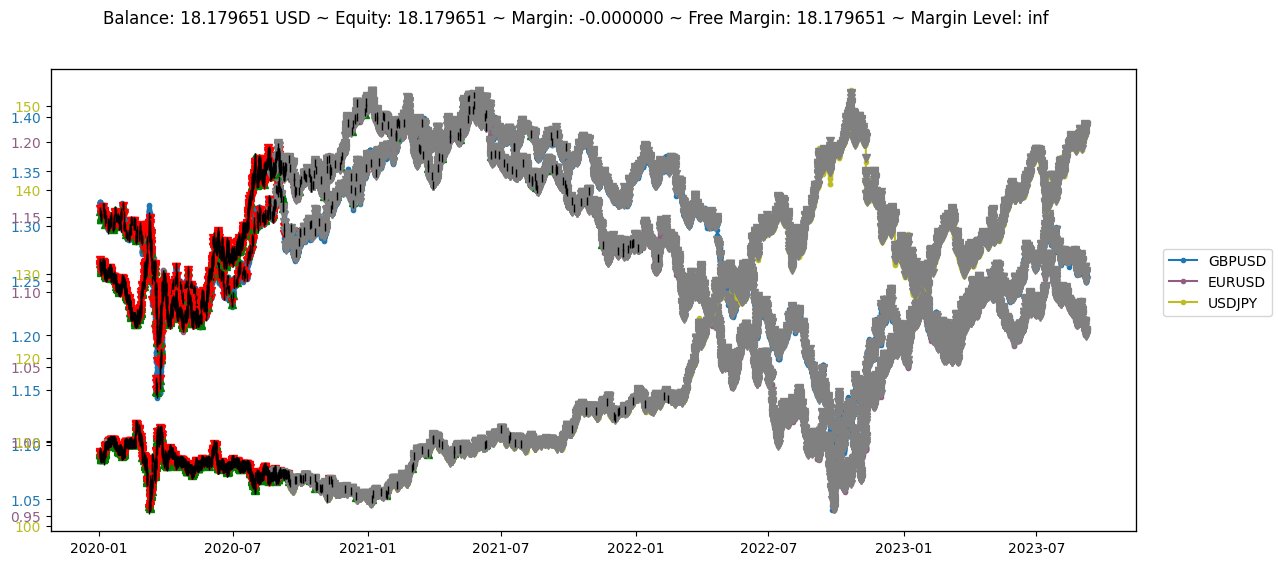

In [28]:
env.render('simple_figure')

## 6. Deploy

In [29]:
# https://www.mql5.com/en/docs/python_metatrader5

#### Đóng tiến trình

In [30]:
# del sim
# del env
# del model
# shut down connection to MetaTrader 5
# mt5.shutdown()